# Data visualization

## Labels Counts and Distributions

In [295]:
import ast
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO


# Read JSON file line by line and concatenate into a single DataFrame
df = pd.read_json("processed_results.json")

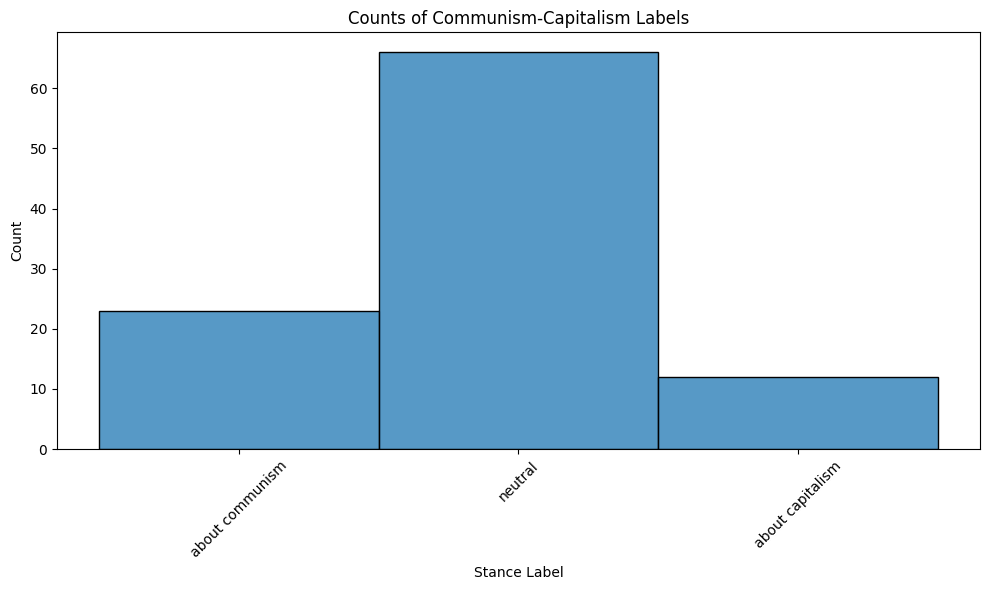

In [296]:
def print_hist(data, title = 'Distribution of Stance Labels'):
    # Plot histogram to show the distribution of labels in data
    plt.figure(figsize=(10, 6))
    sns.histplot(data)
    plt.title(title)
    plt.xlabel('Stance Label')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Extract only the "label" from dictionary columns
data_1 = df["response_stance"].apply(lambda x: x["label"])
print_hist(data_1, 'Counts of Communism-Capitalism Labels')

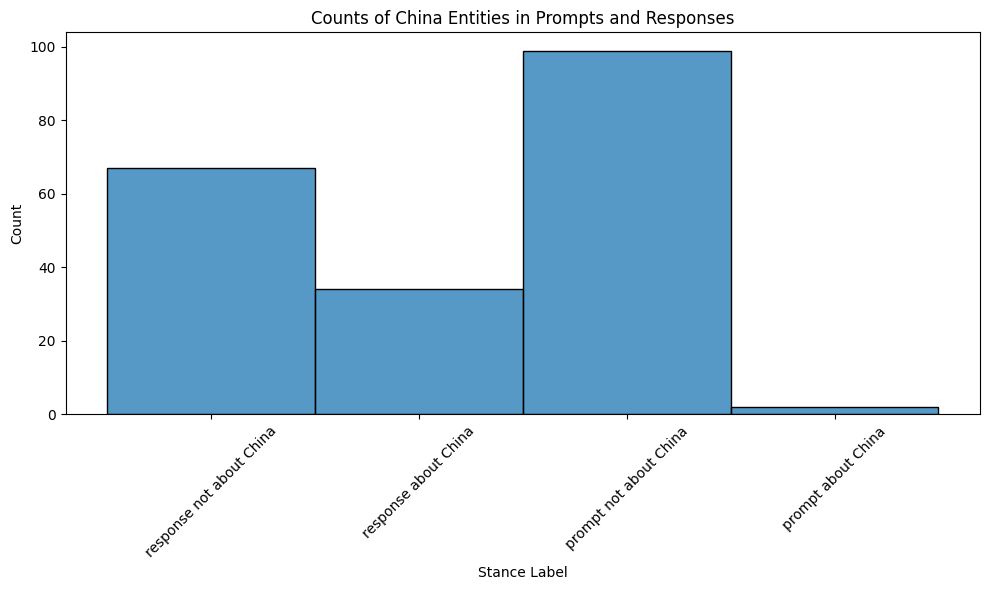

In [297]:

data_2 = df["response_about_china"].apply(lambda x: "response about China" if x else "response not about China")
data_3 = df["prompt_about_china"].apply(lambda x: "prompt about China" if x else "prompt not about China")

print_hist(pd.concat([data_2, data_3]), "Counts of China Entities in Prompts and Responses")

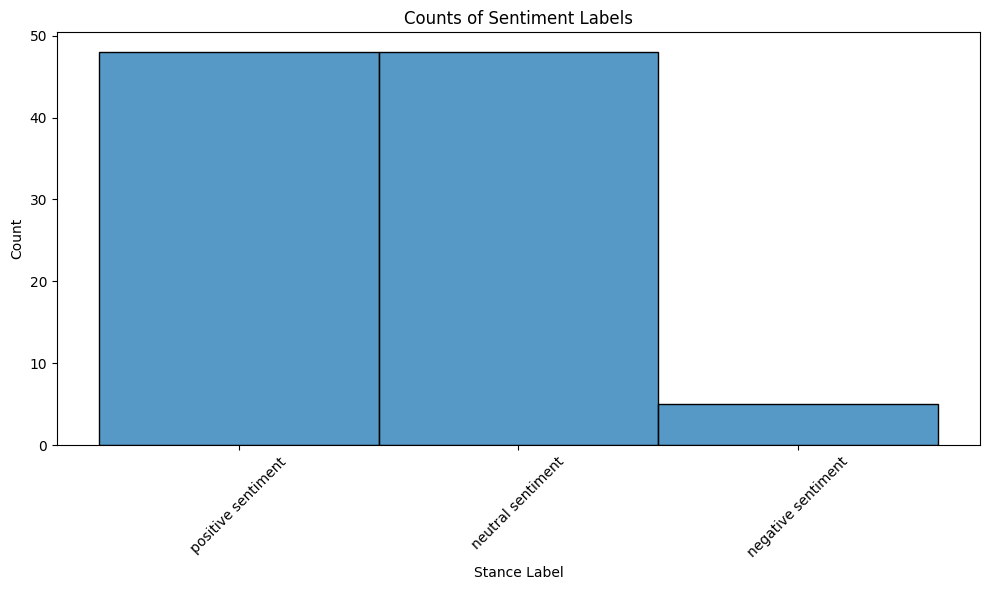

In [298]:
data_4 = df["sentiment"].apply(lambda x: x["label"] + " sentiment")

print_hist(data_4, "Counts of Sentiment Labels")

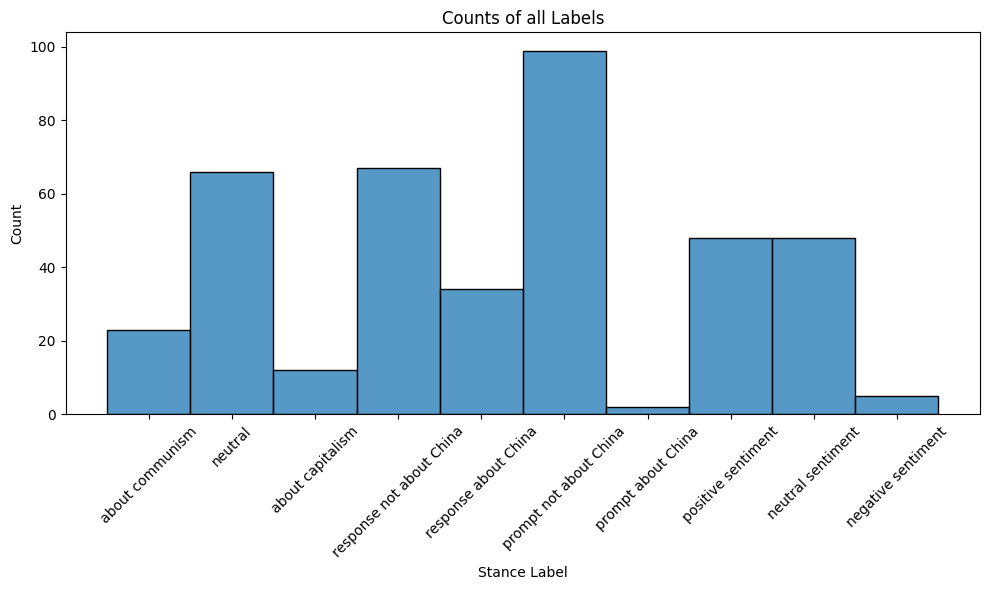

In [299]:
print_hist(pd.concat([data_1, data_2, data_3, data_4]), "Counts of all Labels")

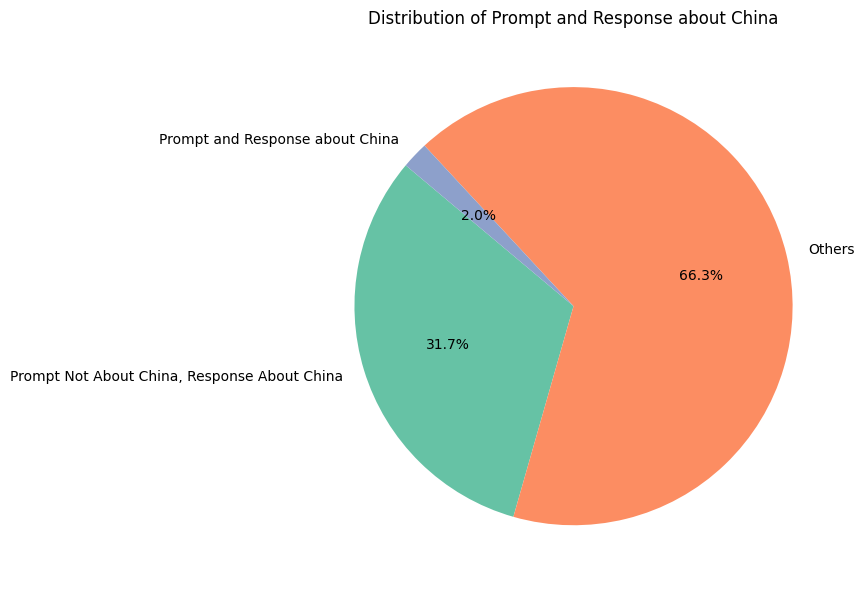

In [300]:
prompt_and_result_about_china_counts = df[(df['prompt_about_china'] == True) & (df['response_about_china'] == True)].shape[0]
prompt_not_about_china_and_result_about_china_counts = df[(df['prompt_about_china'] == False) & (df['response_about_china'] == True)].shape[0]
other = df.shape[0] - (prompt_and_result_about_china_counts + prompt_not_about_china_and_result_about_china_counts)
 
def plot_pie(data, title):
    plt.figure(figsize=(8, 6))
    counts = data['counts']
    labels = data['labels']
    colors=sns.color_palette('Set2')
    plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.tight_layout()
    plt.show()

data = {'counts' : [prompt_not_about_china_and_result_about_china_counts, other, prompt_and_result_about_china_counts], 'labels' : ['Prompt Not About China, Response About China', 'Others', 'Prompt and Response about China']}
plot_pie(data, 'Distribution of Prompt and Response about China')


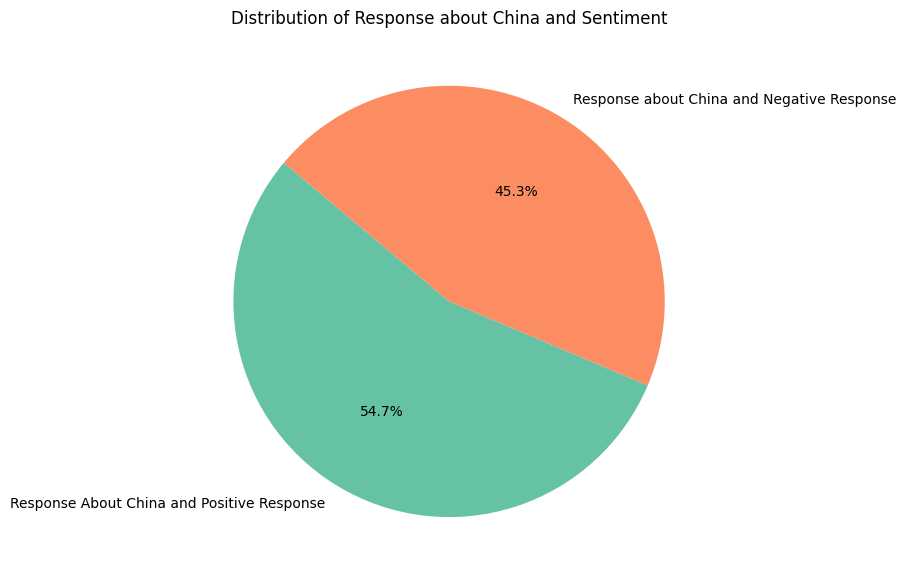

In [310]:
response_china_positive = df[df['response_about_china'] == True & df['sentiment'].apply(lambda x: x['label'] == 'positive')].shape[0]
response_china_negative = df[df['response_about_china'] == True & df['sentiment'].apply(lambda x: x['label'] == 'negative')].shape[0]

labels = ['Response About China and Positive Response', 'Response about China and Negative Response']

plot_pie({'counts' : [response_china_positive, response_china_negative], 'labels' : labels}, 'Distribution of Response about China and Sentiment')

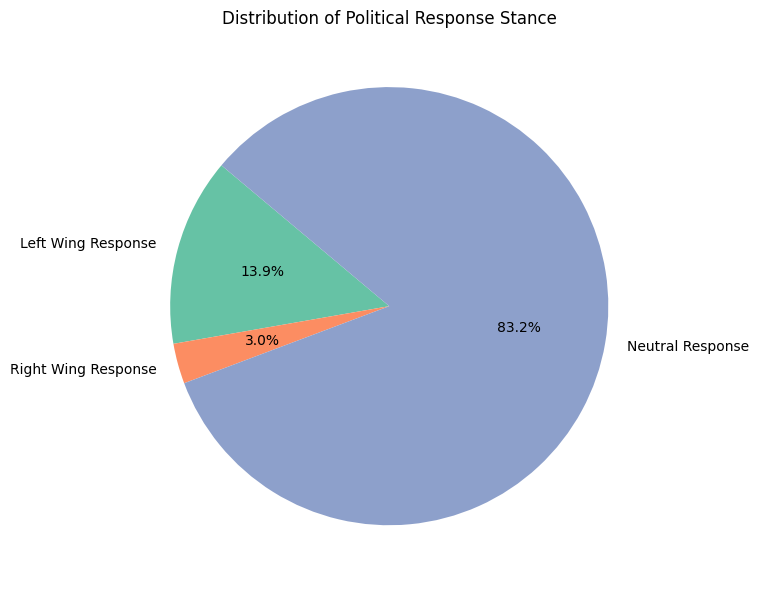

In [302]:
left_wing_response = df[df['left_right_stance'].apply(lambda x: x['label'] == 'left wing')].shape[0]
right_wing_response = df[df['left_right_stance'].apply(lambda x: x['label'] == 'right wing')].shape[0]
neutral_response = df[df['left_right_stance'].apply(lambda x: x['label'] == 'center')].shape[0]

labels = ['Left Wing Response', 'Right Wing Response', 'Neutral Response']
plot_pie({'counts' : [left_wing_response, right_wing_response, neutral_response], 'labels' : labels}, 'Distribution of Political Response Stance')

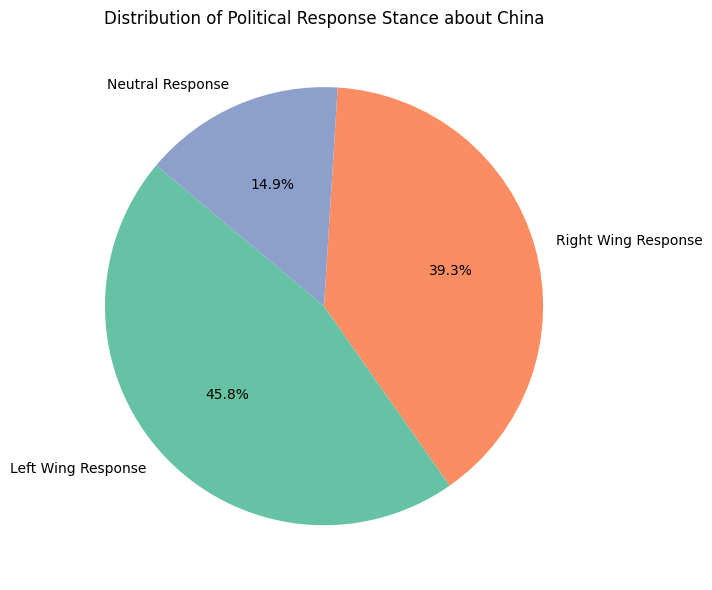

In [303]:
left_wing_response_china = df[df['response_about_china'] == True & df['left_right_stance'].apply(lambda x: x['label'] == 'left wing')].shape[0]
right_wing_response_china = df[df['response_about_china'] == True & df['left_right_stance'].apply(lambda x: x['label'] == 'right wing')].shape[0]
neutral_response_china = df[df['response_about_china'] == True & df['left_right_stance'].apply(lambda x: x['label'] == 'center')].shape[0]

plot_pie({'counts' : [left_wing_response_china, right_wing_response_china, neutral_response_china], 'labels' : labels}, 'Distribution of Political Response Stance about China')

## Stance scores distributions

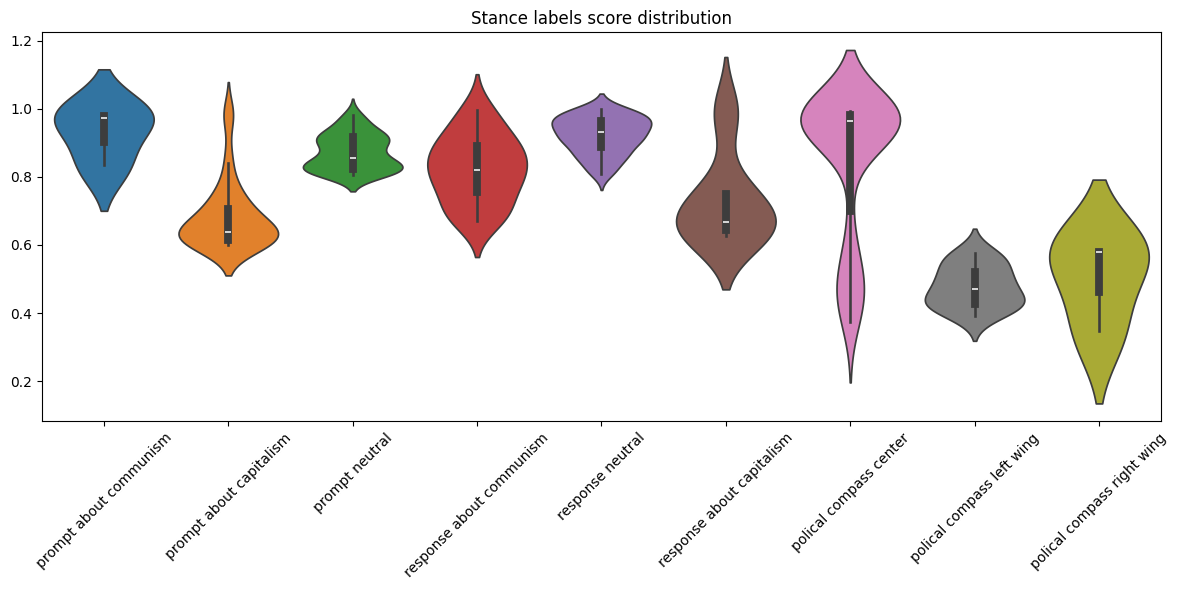

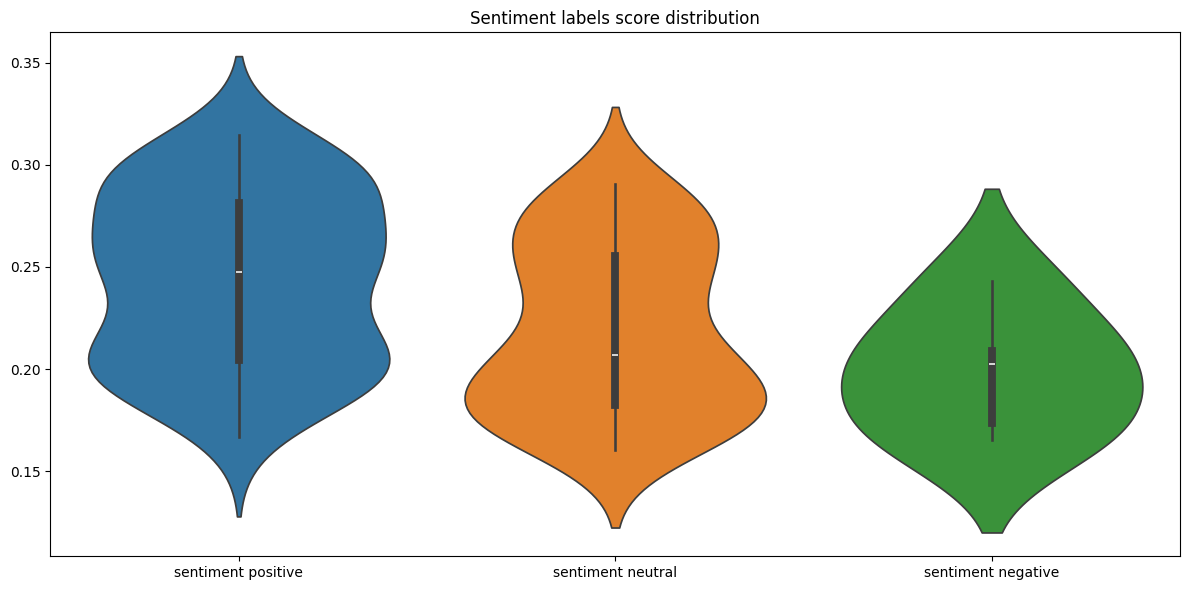

In [304]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

score_df = pd.DataFrame()
sentiment_df = pd.DataFrame()
columns = [col for col in df.columns if "stance" in col]
for col in columns:
    unique_labels = df[col].apply(lambda x: x["label"]).unique()
    for value in unique_labels:
        score_df[f"{col}_{value}".replace("_stance", "").replace("_", " ").replace("left right", "polical compass")] = df[col].apply(lambda x: x["score"] if x["label"] == value else None)

for value in df["sentiment"].apply(lambda x: x["label"]).unique():
    unique_labels = df["sentiment"].apply(lambda x: x["label"]).unique()
    for value in unique_labels:
        sentiment_df[f"sentiment_{value}".replace("_stance", "").replace("_", " ").replace("left right", "polical compass")] = df["sentiment"].apply(lambda x: x["score"] if x["label"] == value else None)

plt.figure(figsize=(12, 6))
sns.violinplot(data=score_df)
plt.title("Stance labels score distribution")
plt.xticks(rotation=45)
plt.tight_layout()

plt.figure(figsize=(12, 6))
sns.violinplot(data=sentiment_df)
plt.title("Sentiment labels score distribution")
plt.tight_layout()


## Correlation between labels

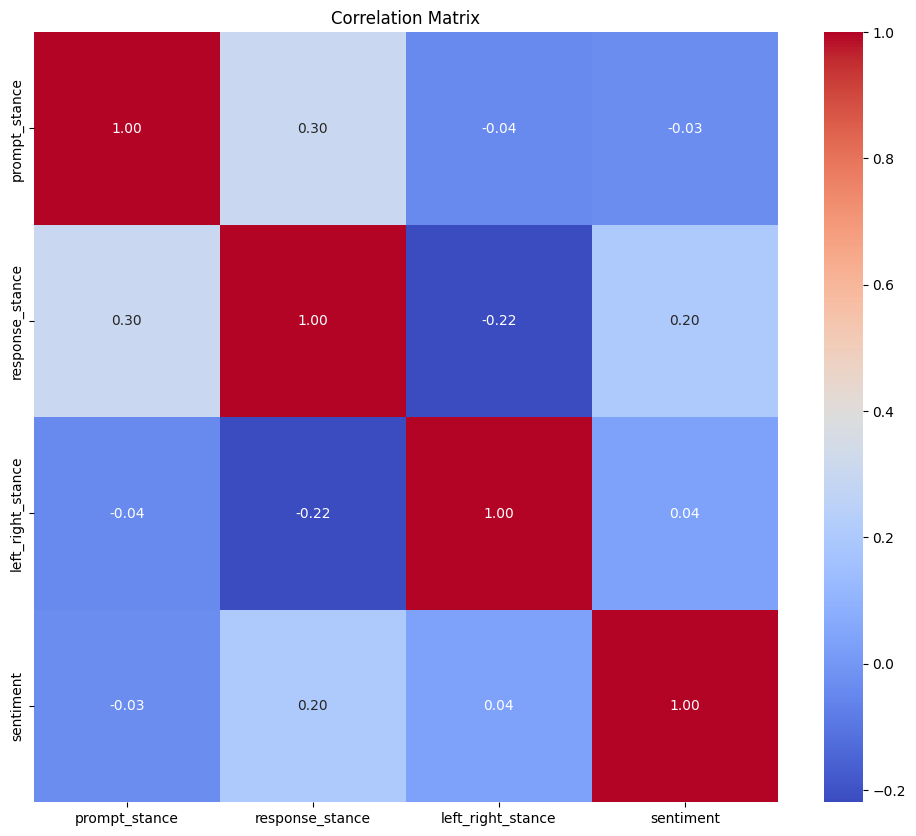

In [305]:
def extract_scores(df):
    def map_label_to_score(row):
        label = row['label']
        score = row['score']
        if label in ['positive', 'about capitalism', 'right wing']:
            return score
        elif label in ['negative', 'about communism', 'left wing']:
            return -score
        else:
            return 1 - score
       
    scores = {}
    labels = ['prompt_stance', 'response_stance', 'left_right_stance', 'sentiment']
    
    for label in labels:
        scores[f'{label}'] = df[label].apply(map_label_to_score)
    
    return pd.DataFrame(scores)

def plot_correlation_matrix(df):
    """ Crea e visualizza la matrice di correlazione """
    corr_matrix = df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()

# Estrai i punteggi e calcola la correlazione
score_df = extract_scores(df)
score_df = score_df.loc[:, (score_df != 0).any(axis=0)]
plot_correlation_matrix(score_df)

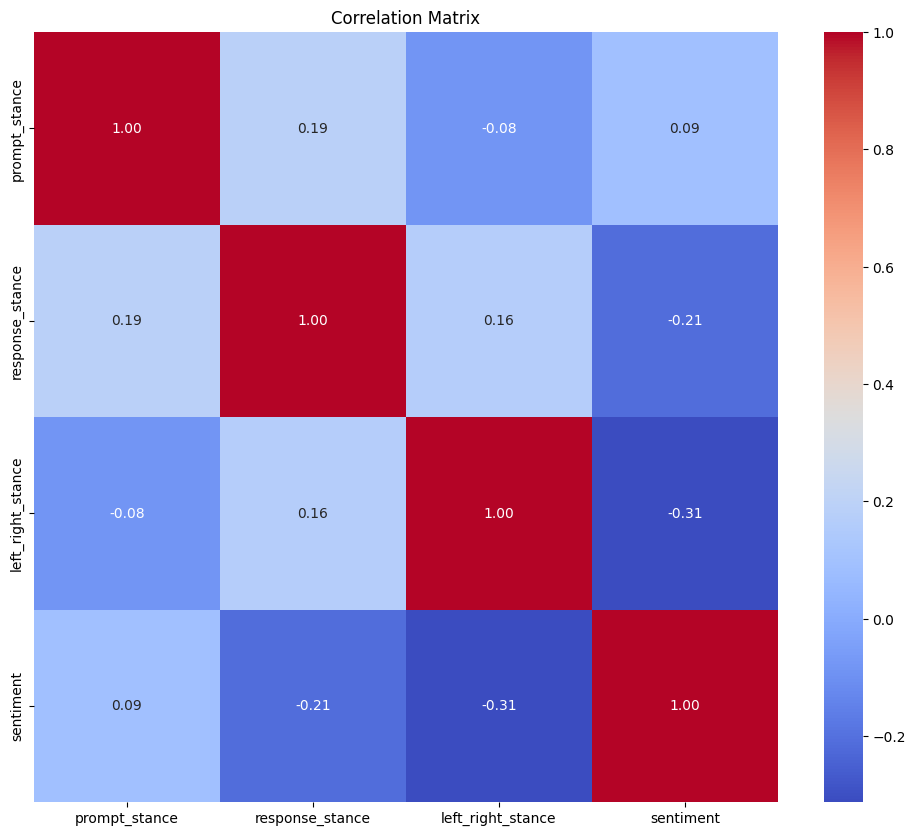

In [306]:
def extract_scores(df):
    def map_label_to_score(row):
        label = row['label']
        score = row['score']
        if label in ['positive', 'about capitalism', 'right wing']:
            return 1
        elif label in ['negative', 'about communism', 'left wing']:
            return -1
        else:
            return 0
       
    scores = {}
    labels = ['prompt_stance', 'response_stance', 'left_right_stance', 'sentiment']
    
    for label in labels:
        scores[f'{label}'] = df[label].apply(map_label_to_score)
    
    return pd.DataFrame(scores)

def plot_correlation_matrix(df):
    """ Crea e visualizza la matrice di correlazione """
    corr_matrix = df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()

# Estrai i punteggi e calcola la correlazione
score_df = extract_scores(df)
score_df = score_df.loc[:, (score_df != 0).any(axis=0)]
plot_correlation_matrix(score_df)

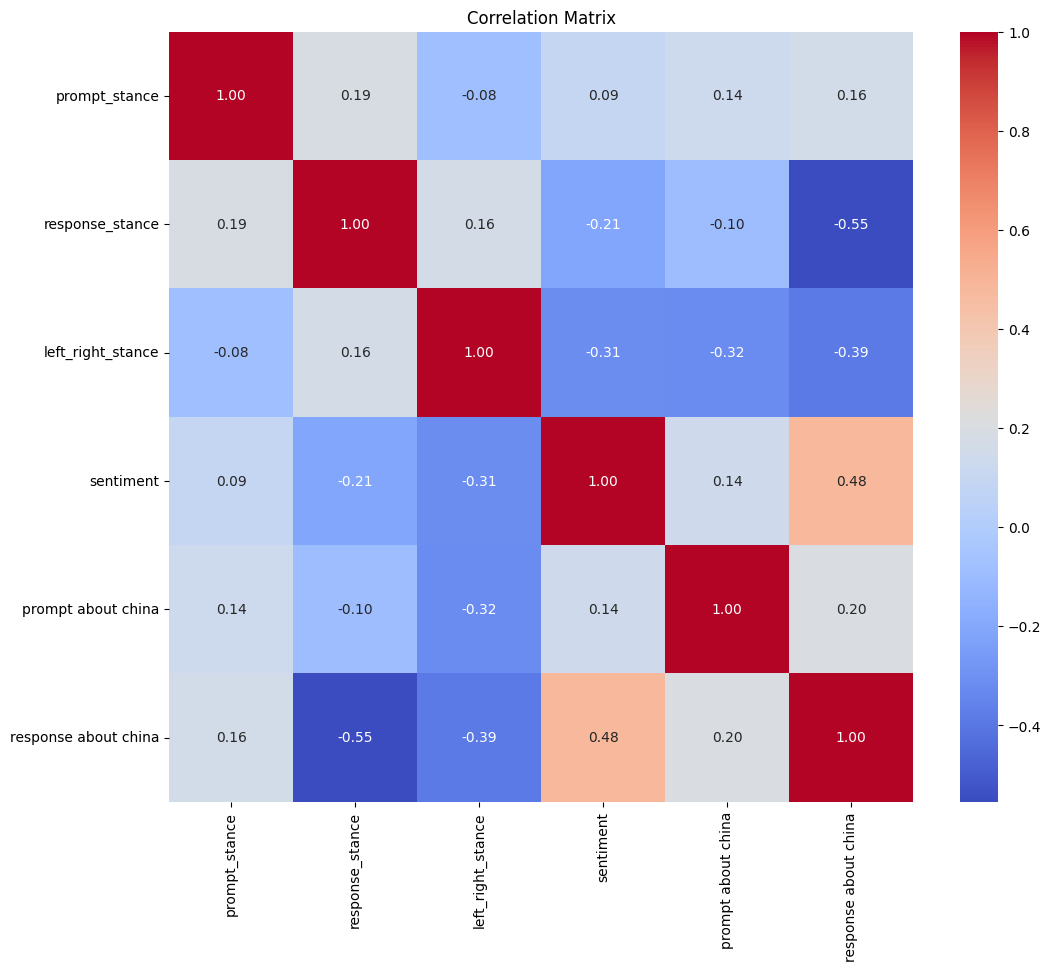

In [307]:
def extract_scores(df):
    def map_label_to_score(row):
        label = row['label']
        score = row['score']
        if label in ['positive', 'about capitalism', 'right wing']:
            return 1
        elif label in ['negative', 'about communism', 'left wing']:
            return -1
        else:
            return 0
       
    scores = {}
    labels = ['prompt_stance', 'response_stance', 'left_right_stance', 'sentiment']
    about_china_labels = ['prompt_about_china', 'response_about_china']

    
    for label in labels:
        scores[f'{label}'] = df[label].apply(map_label_to_score)
    for label in about_china_labels:
        scores[label.replace("_", " ")] = df[label].apply(lambda x: 1 if x else -1)
    
    return pd.DataFrame(scores)

def plot_correlation_matrix(df):
    """ Crea e visualizza la matrice di correlazione """
    corr_matrix = df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()

# Estrai i punteggi e calcola la correlazione
score_df = extract_scores(df)
score_df = score_df.loc[:, (score_df != 0).any(axis=0)]
plot_correlation_matrix(score_df)

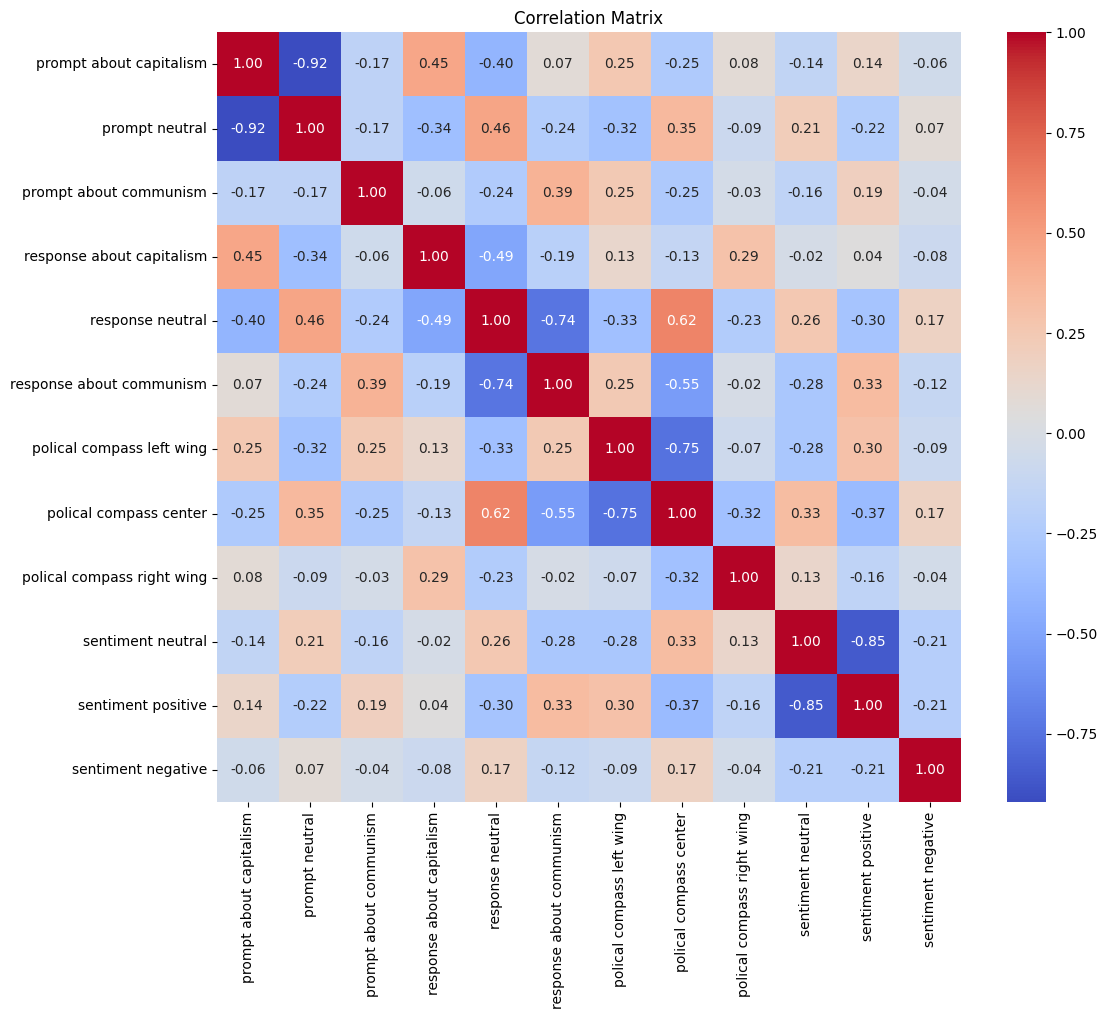

In [308]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

def extract_scores(df):
    """ Estrai gli score dalle colonne rilevanti e crea un nuovo DataFrame con tutte le combinazioni di label """
    scores = {}
    labels = ['prompt_stance', 'response_stance', 'left_right_stance', 'sentiment']
    
    for label in labels:
        for value in ['about capitalism', 'neutral', 'about communism', 'left wing', 'center', 'right wing', 'positive', 'negative']:
            scores[f'{label} {value}'.replace("_stance", "").replace("_", " ").replace("left right", "polical compass")] = df[label].apply(lambda x: x['score'] if x['label'] == value else 0)
    
    return pd.DataFrame(scores)

def plot_correlation_matrix(df):
    """ Crea e visualizza la matrice di correlazione """
    corr_matrix = df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()

# Estrai i punteggi e calcola la correlazione
score_df = extract_scores(df)
score_df = score_df.loc[:, (score_df != 0).any(axis=0)]
plot_correlation_matrix(score_df)

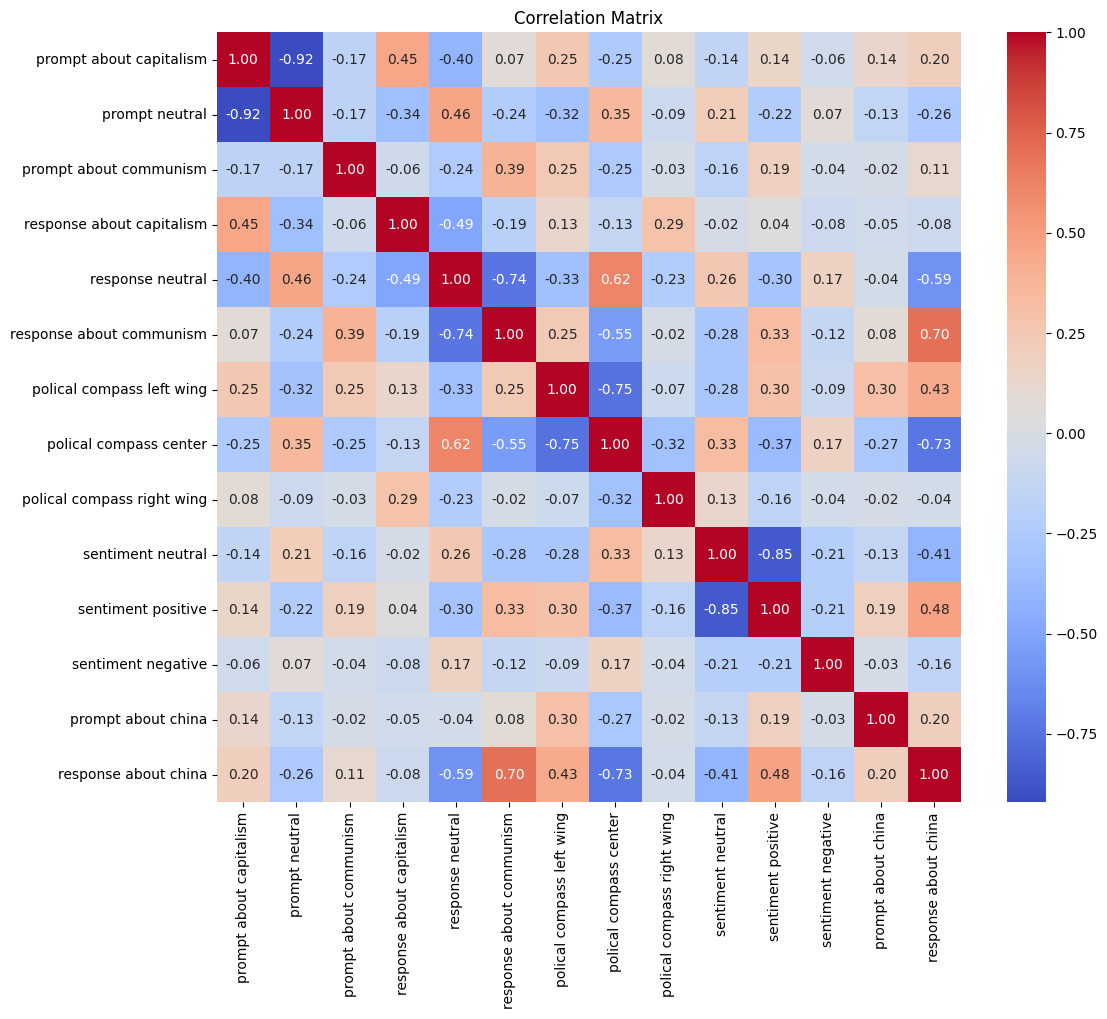

In [309]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

def extract_scores(df):
    """ Estrai gli score dalle colonne rilevanti e crea un nuovo DataFrame con tutte le combinazioni di label """
    scores = {}
    labels = ['prompt_stance', 'response_stance', 'left_right_stance', 'sentiment']
    about_china_labels = ['prompt_about_china', 'response_about_china']
    label_values = ['about capitalism', 'neutral', 'about communism', 'left wing', 'center', 'right wing', 'positive', 'negative']
    
    for label in labels:
        for value in label_values:
            scores[f'{label} {value}'.replace("_stance", "").replace("_", " ").replace("left right", "polical compass")] = df[label].apply(lambda x: x['score'] if x['label'] == value else 0)
    for label in about_china_labels:
        scores[label.replace("_", " ")] = df[label].apply(lambda x: 1 if x else -1)
    
    return pd.DataFrame(scores)

def plot_correlation_matrix(df):
    """ Crea e visualizza la matrice di correlazione """
    corr_matrix = df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()

# Estrai i punteggi e calcola la correlazione
score_df = extract_scores(df)
score_df = score_df.loc[:, (score_df != 0).any(axis=0)]
plot_correlation_matrix(score_df)